In [2]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Image size
s = 224

# Load and preprocess images
def load_and_preprocess_images(category_directory, class_label):
    dataset = []
    label = []
    for filename in os.listdir(category_directory):
        img = cv2.imread(os.path.join(category_directory, filename))  # Read image
        if img is not None:
            img = cv2.resize(img, (s, s))  # Resize to s x s
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = img.astype(np.float32) / 255.0  # Cast to float and normalize pixel values to [0, 1]
            dataset.append(img)  # Append image to dataset
            label.append(class_label)  # Assign class label
    return dataset, label


In [4]:
# Define categories and labels
categories = ['Shingles', 'Chickenpox', 'Cutaneous-larva-migrans', 'Ringworm']
labels = range(len(categories))

# Load and preprocess images for each category
dataset = []
label = []
for category, label_id in zip(categories, labels):
    data, labels = load_and_preprocess_images(category, label_id)
    dataset.extend(data)
    label.extend(labels)

In [5]:
# Convert to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Check shapes
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (115, 224, 224, 3)
Label shape: (115,)


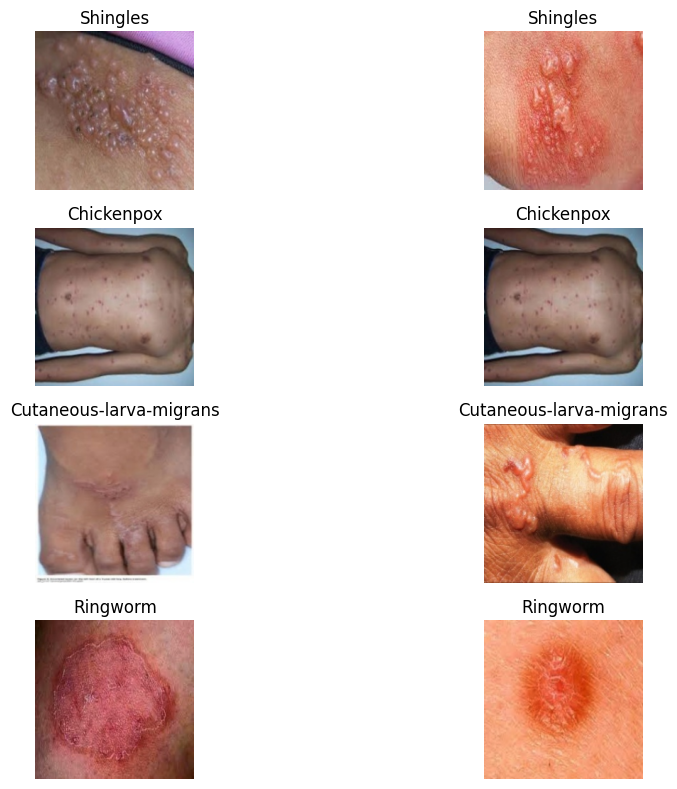

In [16]:
# Display two sample images for each category
def display_sample_images(category_directories, num_samples=2):
    plt.figure(figsize=(12, 8))
    for idx, category_directory in enumerate(category_directories):
        images = [cv2.imread(os.path.join(category_directory, file)) for file in os.listdir(category_directory)[:num_samples]]
        for i, img in enumerate(images):
            img = cv2.resize(img, (s, s))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(category_directories), num_samples, idx*num_samples + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(categories[idx])
    plt.tight_layout()
    plt.show()

# Display sample images
category_directories = [os.path.join('.', category) for category in categories]
display_sample_images(category_directories)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, stratify=label, random_state=43)

# One-hot encode the labels
num_classes = len(categories)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)


In [7]:
# Load pre-trained VGG16 model without top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(s, s, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [9]:
# Fine-tuning top layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * np.exp(0.1 * (10 - epoch))

lr_schedule = LearningRateScheduler(lr_scheduler)

In [10]:
# Model definition
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a lower initial learning rate
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 27562308 (105.14 MB)
Trainable params: 19927044 (76.02 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [11]:
# Early stopping and ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=20,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop, checkpoint, lr_schedule]
)


Epoch 1/20



3/3 [==============================] - ETA: 0s - loss: 1.7805 - accuracy: 0.2935

F:\anconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 23s 7s/step - loss: 1.7805 - accuracy: 0.2935 - val_loss: 1.4030 - val_accuracy: 0.5217 - lr: 1.0000e-04
Epoch 2/20
3/3 [==============================] - 18s 7s/step - loss: 1.2863 - accuracy: 0.4565 - val_loss: 1.1178 - val_accuracy: 0.4348 - lr: 1.0000e-04
Epoch 3/20
3/3 [==============================] - 20s 7s/step - loss: 1.1212 - accuracy: 0.5217 - val_loss: 0.9301 - val_accuracy: 0.6087 - lr: 1.0000e-04
Epoch 4/20
3/3 [==============================] - 19s 7s/step - loss: 0.7662 - accuracy: 0.6739 - val_loss: 0.7920 - val_accuracy: 0.7391 - lr: 1.0000e-04
Epoch 5/20
3/3 [==============================] - 18s 7s/step - loss: 0.7977 - accuracy: 0.6413 - val_loss: 0.6844 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 6/20
3/3 [==============================] - 18s 6s/step - loss: 0.5253 - accuracy: 0.8152 - val_loss: 0.6724 - val_accuracy: 0.7391 - lr: 1.0000e-04
Epoch 7/20
3/3 [==============================] - 17s 6s/step - loss: 0.5139 - ac

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate evaluation metrics
evaluation_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

for metric, value in evaluation_metrics.items():
    print(f'{metric}: {value}')

1/1 [==============================] - 3s 3s/step - loss: 0.2732 - accuracy: 0.9130
Loss: 0.27320054173469543, Accuracy: 0.9130434989929199
1/1 [==============================] - 3s 3s/step
Accuracy: 0.9130434782608695
Precision: 0.932367149758454
Recall: 0.9130434782608695
F1 Score: 0.9129572118702552


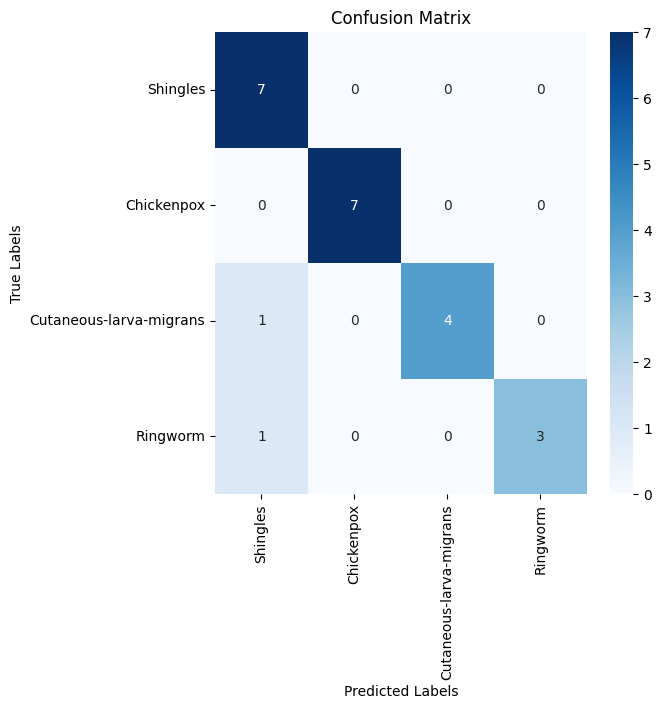

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

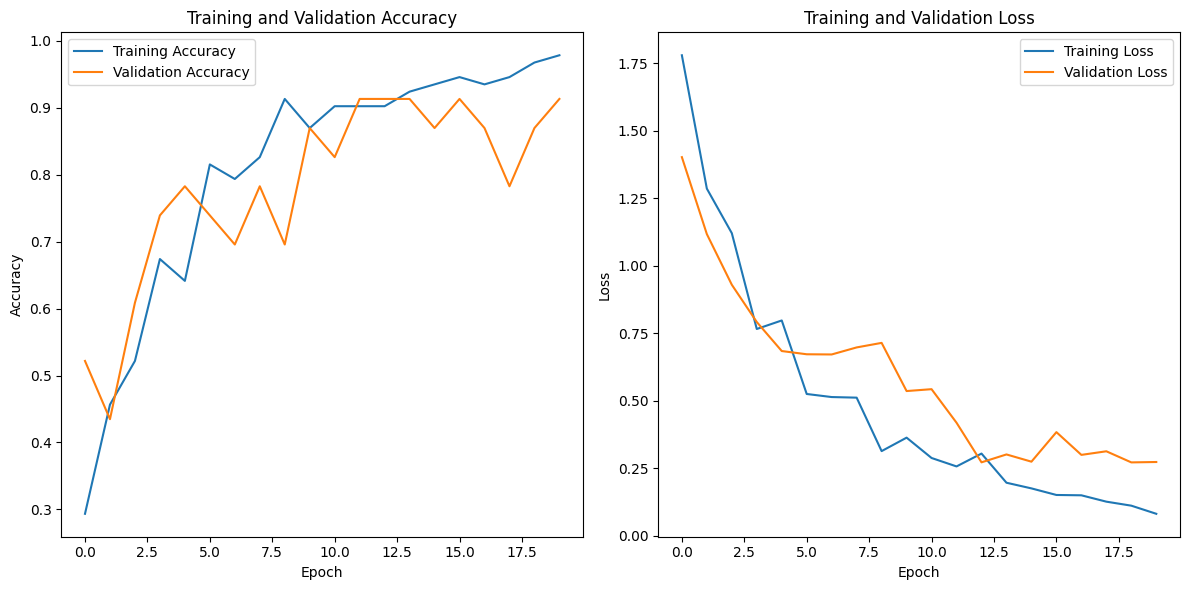

In [14]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Save the model as .h5 file
model.save('Skin.h5')
print("Model saved as 'Skin.h5'")

# Save the model architecture as JSON
model_json = model.to_json()
with open("Skin.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model architecture to 'Skin.json'")

F:\anconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'Skin.h5'
Saved model architecture to 'Skin.json'
